In [1]:
import sys
sys.path.append('/home/users/kokron/Libraries/lim/')
sys.path.append('/home/users/kokron/Projects/preLIMinary/')
from LIM_lightcone import paint_lightcone,make_survey,make_measurements
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import astropy.constants as cu
from scipy.interpolate import interp2d,interp1d
from scipy.optimize import curve_fit
import math
from lim import lim

from nbodykit.algorithms import FFTPower

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as clrs
import matplotlib.cm as cmap
import matplotlib.patches as patches
from matplotlib.patches import Rectangle as rect
from matplotlib.collections import PatchCollection

import time
colors = ['#8a1f1f','#79a43a','#C59D34','#171782', '#cf6717','#ad6faa',
          '#009999','#828282']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)
plt.rcParams['lines.linewidth'] = 3.0
plt.rcParams['axes.linewidth'] = 2.
plt.rcParams['figure.facecolor']='white'
%matplotlib inline

In [2]:
def linear_color(col1,col2):
    cmap = clrs.LinearSegmentedColormap.from_list("", [col1,col2])
    return cmap

#############################################

def SFR_Mz_2dinterp(M,z,SFR_file):
    '''
    Returns SFR(M,z) interpolated from tables of 1+z, log10(Mhalo/Msun) and 
    log10(SFR / (Msun/yr)), in three columns, where 1+z is the innermost index 
    (the one running fast compared with the mass)
    '''
    #SFR_folder = os.path.dirname(os.path.realpath(__file__)).split("source")[0]+'SFR_tables/'
    #try:
    #    x = np.loadtxt(SFR_folder+SFR_file)
    #except:
    x = np.loadtxt(SFR_file)
    zb = np.unique(x[:,0])-1.
    logMb = np.unique(x[:,1])
    logSFRb = x[:,2].reshape(len(zb),len(logMb),order='F')
    
    logSFR_interp = interp2d(logMb,zb,logSFRb,bounds_error=False,fill_value=-40.)
    
    if 'sfr_table_Behroozi' in SFR_file:
        M *= 0.678
        
    try:
        logM = np.log10((M).value)
    except:
        logM = np.log10(M)
    if np.array(z).size>1:
        SFR = np.zeros(logM.size)
        for ii in range(0,logM.size):
            SFR[ii] = 10.**logSFR_interp(logM[ii],z[ii])
    else:
        SFR = 10.**logSFR_interp(logM,z)
    
    return SFR

In [3]:
def Dnu_from_Dz(nu,z,Dz):
    nuObs = nu/(1.+z)
    zmin = z-Dz/2.
    zmax = z+Dz/2.
    nu_zmin = nu/(1.+zmin)
    nu_zmax = nu/(1.+zmax)
    return nuObs, abs(nu_zmin-nu_zmax)

def lim_params(SFR_file, Tsys,z,Dz,sigma_scatter=0.3,sig_SFR=0.6,
              Nfeeds = 1000, beam = 4, tobs = 1000,
              Omega_field = 100,dnu=10):
    #Setting line model and observational parameters. Default with RSD, smooth, one_halo, at z=2.5.
    cosmo_fid = dict(cosmo_input_camb={'H0':67.8,'ombh2':0.02312,'omch2':0.118002988,
                      'As':2.23832e-9,'ns':0.96,'mnu':0.06, 'f_NL':0})
    h=cosmo_fid['cosmo_input_camb']['H0']/100
        
    nu=115.271*u.GHz
    nuObs, Dnu = Dnu_from_Dz(nu, z, Dz)
    model_params = dict(nu=nu, nuObs=nuObs, 
                        sigma_scatter=sigma_scatter,
                        hmf_model='Tinker', 
                        bias_model='Tinker10', 
                        model_type='ML',
                        Mmin = 1e10/h*u.Msun, Mmax=1e15/h*u.Msun,
                        model_par={'alpha':1.37, 'beta':-1.74, 'dMF':1.0,'SFR_file':SFR_file,'sig_SFR':sig_SFR},
                        model_name='TonyLi', 
                        do_onehalo=True, do_RSD=True, smooth=False, 
                        kmin=1e-5*u.Mpc**-1, kmax=1e3*u.Mpc**-1, 
                        nk=512, nmu=10000, 
                        nT=2**21, Tmin_VID = 1.0e-4*u.uK)
    obs_params = dict(Delta_nu=Dnu, dnu=dnu*u.MHz, 
                      Tsys_NEFD=Tsys*u.K, 
                      Nfeeds=Nfeeds, 
                      beam_FWHM=beam*u.arcmin, 
                      tobs=tobs*u.hr,
                      Omega_field=Omega_field*u.deg**2, 
                      Nfield=1)
                
    obs_params.update(model_params)
    obs_params.update(cosmo_fid)
    return obs_params

def LC_params(do_exSFR, exSFR, exSFR_pars, Tsys,
              zmin_obs, zmax_obs,zmin=2.2,zmax=3.5,
              sigma_scatter=0.3,sig_SFR=0.6,
              Nfeeds = 1000, beam = 4, tobs = 1000,
              alpha = 1.37, beta = -1.74,
              dnu=10,
              RAObs_edge = 4.5, DECObs_edge = 4.5,smooth=False):
    nu_CO=115.271*u.GHz

    model_params=dict(halo_lightcone_dir='/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/', 
                      lines=dict(CO=True),
                      models=dict(CO=dict(model_name='CO_Li16',
                                          model_pars={'alpha':alpha,'beta':beta,'delta_mf':1,'sigma_L':sigma_scatter})),
                      do_external_SFR = do_exSFR, external_SFR = exSFR,
                      SFR_pars=exSFR_pars,
                      supersample=1,
                      Nmu=10,
                      dk=0.01*u.Mpc**-1)
    obs_params=dict(zmin = zmin, zmax = zmax,
                    RAObs_min=-RAObs_edge*u.deg,RAObs_max=RAObs_edge*u.deg,
                    DECObs_min=-DECObs_edge*u.deg,DECObs_max=DECObs_edge*u.deg,
                    RA_min=-5.0*u.deg,RA_max=5.0*u.deg,
                    DEC_min=-5.0*u.deg,DEC_max=5.0*u.deg,
                    nuObs_max=nu_CO/(1+zmin_obs), nuObs_min=nu_CO/(1+zmax_obs),
                    beam_FWHM=beam*u.arcmin, 
                    dnu=dnu*u.MHz,
                    Tsys=Tsys*u.K, 
                    Nfeeds=Nfeeds, 
                    tobs=tobs*u.hr,
                    linear_VID_bin=False, Tmin_VID =-0.5*u.uK,Nbin_hist=50,Tmax_VID=100*u.uK,
                    do_smooth=False,remove_noise=True)
    obs_params.update(model_params)
    return obs_params

In [4]:
def func(M,Ma,Mb,a,b,c):
    M0 = -6
    return np.log10(10**M0*((M/10**Ma)**a)*(1+(M/10**Mb)**b)**c)

def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

# def func_dongwoo(M, ):
z = 2.8
logM=np.log10(np.logspace(10, 14, 100))
sfr_um = SFR_Mz_2dinterp(10**logM,z,'../SFR_tables/sfr_table_normalmean_UniverseMachine_medianFalse_clean_solMass.dat')
sfr_bwc = SFR_Mz_2dinterp(10**logM,z,'../SFR_tables/sfr_table_Behroozi.dat')          
popt_um, pcov = curve_fit(func, 10**logM[np.logical_and(np.log10(sfr_um)>-3 , logM>10.5)], np.log10(sfr_um)[np.logical_and(np.log10(sfr_um)>-3, logM>10.5)],
                         p0=[8,12.3,1.9,3,-1.4])
popt_bwc, pcov = curve_fit(func, 10**logM[np.log10(sfr_bwc)>-3], np.log10(sfr_bwc)[np.log10(sfr_bwc)>-3],
                          p0=[8,12.3,1.9,3,-0.7])

print('Universe Machine SFR at z = ',z)
print('-------------------------------')
print('M0 = {:.2f}, Ma = {:.2f}, Mb = {:.2f}'.format(-6,popt_um[0],popt_um[1]))
print('a = {:.2f}, b = {:.2f}, c = {:.2f}'.format(popt_um[2],popt_um[3],popt_um[4]))
print('')
print('BWC13 SFR at z = ',z)
print('-------------------------------')
print('M0 = {:.2f}, Ma = {:.2f}, Mb = {:.2f}'.format(-6,popt_bwc[0],popt_bwc[1]))
print('a = {:.2f}, b = {:.2f}, c = {:.2f}'.format(popt_bwc[2],popt_bwc[3],popt_bwc[4]))
print('')

def sfr_dc(m, A, B, C, M_h):
    '''
    Parametrization for SFR(M) based off of 2111.05931 parametrization.
    Equation is: 
    
    SFR(M) = C / ((M/M_h)**A + (M/M_h)**B)
    
    so
    A = low-M slope
    B = high-M slope
    C = amplitude at tilt scale
    M_h = tilt mass
    
    
    Note original use is for L_CO (M_h) but here we'll 
    choose SFR(M_h) instead. Should be equivalent but double check.
    '''
    ratio = m/10**M_h
    
    return np.log10(C/(ratio**A + ratio**B))

def del_A(m, A, B, C, m_h):
    ratio = m/10**M_h
    
    numerator = -C* (ratio)**A *np.log(ratio)
    denom = ((ratio)**A + (ratio)**B)**2 
    
    return np.log10(numerator/denom)

def del_B(m, A, B, C, m_h):
    ratio = m/10**M_h
    
    numerator = -C *(ratio)**B *np.log(ratio)
    denom = ((ratio)**A + (ratio)**B)**2 
    
    return np.log10(numerator/denom)

 
def del_C(m, A, B, C, m_h):
    ratio = m/10**M_h
    
    return np.log10(1/(ratio**A + ratio**B))

def del_M(m, A, B, C, m_h):
    ratio = m/10**M_h
    
    numerator = -(C*(-A*ratio*(ratio)**(-1 + A)* np.log(10) -B*ratio* (ratio)**(-1 + B) * np.log(10)))
    
    denom = (ratio**A + ratio**B)**2
    
    return np.log10(numerator/denom)

popt_um, pcov = curve_fit(sfr_dc, 10**logM[np.logical_and(np.log10(sfr_um)>-3 , logM>10.5)], np.log10(sfr_um)[np.logical_and(np.log10(sfr_um)>-3, logM>10.5)],
                         p0=[3,-1.4,10,12.5])
popt_bwc, pcov = curve_fit(sfr_dc, 10**logM[np.log10(sfr_bwc)>-3], np.log10(sfr_bwc)[np.log10(sfr_bwc)>-3],
                          p0=[3,-1.4,10,12.5])

Universe Machine SFR at z =  2.8
-------------------------------
M0 = -6.00, Ma = 8.09, Mb = 12.46
a = 1.87, b = 4.65, c = -0.89

BWC13 SFR at z =  2.8
-------------------------------
M0 = -6.00, Ma = 8.20, Mb = 12.32
a = 1.96, b = 6.53, c = -0.32



/home/users/kokron/Libraries/miniconda3/envs/nbodykit-env/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10
/home/users/kokron/Libraries/miniconda3/envs/nbodykit-env/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: divide by zero encountered in log10


In [5]:
poptvec = [popt_bwc, popt_um]
nparams = len(poptvec[0])

derivvec = np.zeros(shape=(3, nparams))

###Observational params
Tsys = 0
# zmin_obs, zmax_obs = 2.4,3.4

zmin_obs, zmax_obs = 2.6,2.8

sigma_scatter=0.3
####

st = time.time()

###Make first map to set the seed
A, B, C, M_h = popt_bwc

model_first = dict(A=A, B=B, C=C, M_h=10**M_h)

CO = make_measurements(LC_params(True, 'Dongwoo_SFR', model_first, Tsys,zmin_obs,zmax_obs, beam=4.5))


kmax = 1

Tbin_edges = CO.sigmaN*(CO.supersample**1.5)*6

lower_end = np.min([-Tbin_edges.value, -0.5])*u.uK
higher_end = np.max([Tbin_edges.value, 100])*u.uK

Nbin_hist = 25

kstar = 0.1
####
stepvec = np.array([0.01, 0.01, 0.01, 0.005])
stepvec = np.array([0.01, 0.01, 0.01, 0.01])
for n in range(1):
    fiducial = poptvec[n]

    derivvec[1] = fiducial
    
    derivvec[0] = fiducial*(1-stepvec)
    derivvec[-1] = fiducial*(1+stepvec)
    
    deltavec = 0.5*(derivvec[-1] - derivvec[0])
    
    steparr = [-1, 0]
    
    
    monovec = []

    vidvec = []

    chi2vec = []

    chi2vec_pk = []
    chi2vec_vid = []

    
    #Compute covariance
    A, B, C, M_h = derivvec[1]

    model_vary = dict(A=A, B=B, C=C, M_h=10**M_h)

    CO.update(seed=0,
              SFR_pars = LC_params(True, 'Dongwoo_SFR', model_vary, Tsys,zmin_obs,zmax_obs)['SFR_pars'],
              do_smooth=True,
              Tmin_VID = -0.5*u.uK,
              Tmax_VID = 100*u.uK,
              Nbin_hist = Nbin_hist,
              linear_VID_bin=True)

    CO.Pk_2d
    kmask = CO.k_Pk_poles.value < kmax
    vidvec.append([CO.Ti, CO.Bi_VID])


        
    vid_mask = CO.Bi_VID == 0


    #Check the Nmodes calculation here, might be off or something...
    vid_diag = 1.*CO.Bi_VID_covariance.diagonal()
    vid_diag[vid_mask] = 1

    cov = np.diag(np.hstack([CO.covmat_00.value[kmask], vid_diag]))

    pkfid = CO.Pk_0.value[kmask]
    vidfid = CO.Bi_VID
    true_fid = np.hstack([pkfid, vidfid])

    fid_map = CO.obs_3d_map.value
    derivvar = np.zeros(shape=(2, len(true_fid)))
    print('Fiducial: ', np.min(CO.obs_3d_map), np.max(CO.obs_3d_map))

    print('          A        B            C             M_h')
    mapvec = []
    for param in range(2):
     
        fid_params = derivvec[1]
        
        param_deriv = np.zeros(shape=(2, len(true_fid)))
        
        for i, step in enumerate(steparr):
            mod_params = 1.*fid_params
            
            mod_params[param] = derivvec[step, param]
            
            A, B, C, M_h = mod_params
            print(mod_params)
            model_vary = dict(A=A, B=B, C=C, M_h=10**M_h)

            CO.update(seed=0,
                      SFR_pars = LC_params(True, 'Dongwoo_SFR', model_vary, Tsys,zmin_obs,zmax_obs)['SFR_pars'],
                      do_smooth=True,
                      Tmin_VID = -0.5*u.uK,
                      Tmax_VID = 100*u.uK,
                      Nbin_hist = Nbin_hist,
                      linear_VID_bin=True)
            
            print(np.min(CO.obs_3d_map), np.max(CO.obs_3d_map))

            CO.Pk_2d
            kmask = CO.k_Pk_poles.value < kmax
#             vidvec.append([CO.Ti, CO.Bi_VID])

            pkfid = CO.Pk_0.value[kmask]
    
            vidfid = CO.Bi_VID

            dv_fid = np.hstack([pkfid, vidfid])

            param_deriv[i] = dv_fid
            chi2vec.append(dv_fid)
            mapvec.append(CO.obs_3d_map.value)
        deriv = (param_deriv[0] - param_deriv[1])/(2*deltavec[param])
        derivvar[param] = deriv
        
print(time.time() - st)

/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_152.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_153.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_154.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_155.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_156.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_157.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_158.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_159.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_160.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_161.fits
/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/lightcone_MDPL2UM_162.fits

Set up derivatives with mapvec[0] and mapvec[1] for different binning schemes. 

We'll be plotting the integrand to a generic diagonal part of the Fisher matrix


$$ \sum_i \partial \mathcal{B}_i \frac{1}{\sigma^2 (\mathcal{B}_i)} \partial \mathcal{B}_i $$

where $i$ are the different temperature bins. 

1181305.111020559
65991713.07599091
6411019.044729701
70238209.72200361
2442673007.1149087


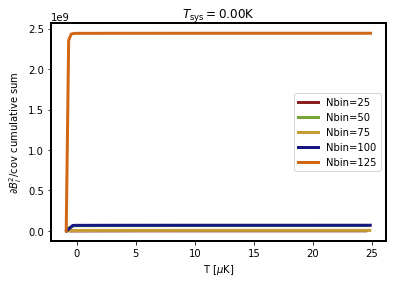

In [6]:
fidvidvec = []


bins = np.linspace(-1, 100, 26)

for nbins in [26, 51, 76, 101, 126]:
    b = np.linspace(-1, 25, nbins)

    forward = np.histogram(mapvec[2], bins=b)[0]
    back, tval = np.histogram(mapvec[3], bins=b)
    
    fidvid = np.histogram(fid_map, bins=b)[0]
    
    fidvidvec.append(fidvid)
    deriv = (forward - back)/(2*deltavec[param])
#     print(tval)

    tvec = 0.5*(tval[1:] + tval[:-1])

    dvec = (tval[1:] - tval[:-1])
        
    vid_idx = fidvid == 0

    fidvid[vid_idx] = 1
    

    plt.plot(tvec, np.cumsum(deriv**2/fidvid), label='Nbin=%d'%(len(tvec)))
    print(np.cumsum(deriv**2/fidvid)[-1])
    
    
#     for tmax in [1, 2, 3, 4, 5, 7.5, 10]:


#         tmax_idx = np.where(0.5*(tval[1:] + tval[:-1]) <= tmax)[0][-1]
        
#         fisherterm = np.sum((deriv**2 / fidvid)[:tmax_idx])
    
#         print('Nbins: %d, Tmax = %d, fisherterm=%.2f'%(len(tval), tmax, fisherterm))
# plt.yscale('log')
plt.xlabel(r'T [$\mu$K]')
plt.ylabel(r'$\partial B_i^2$/cov cumulative sum')
# plt.ylim(1e8, 1e9)
plt.title(r'$T_{\rm sys} = %.2f$K'%Tsys)
plt.legend()

# Look at log binning for the noiseless case

/home/users/kokron/Libraries/miniconda3/envs/nbodykit-env/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/home/users/kokron/Libraries/miniconda3/envs/nbodykit-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/users/kokron/Libraries/miniconda3/envs/nbodykit-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/users/kokron/Libraries/miniconda3/envs/nbodykit-env/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log10
  if sys.path[0] == '':


1316188.5312219884
1347380.0162085278
1391901.4215594626
1396528.327221738
1433256.0202436843


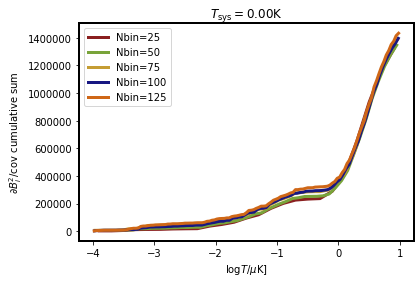

In [7]:
fidvidvec = []


bins = np.linspace(-1, 100, 26)

for nbins in [26, 51, 76, 101, 126]:
    b = np.linspace(-4, 1, nbins)

    forward = np.histogram(np.log10(mapvec[2]), bins=b)[0]
    back, tval = np.histogram(np.log10(mapvec[3]), bins=b)
    
    fidvid = np.histogram(np.log10(fid_map), bins=b)[0]
    
    fidvidvec.append(fidvid)
    deriv = (forward - back)/(2*deltavec[param])
#     print(tval)

    tvec = 0.5*(tval[1:] + tval[:-1])

    dvec = (tval[1:] - tval[:-1])
        
    vid_idx = fidvid == 0

    fidvid[vid_idx] = 1
    

    plt.plot(tvec, np.cumsum(deriv**2/fidvid), label='Nbin=%d'%(len(tvec)))
    print(np.cumsum(deriv**2/fidvid)[-1])
    
    
#     for tmax in [1, 2, 3, 4, 5, 7.5, 10]:


#         tmax_idx = np.where(0.5*(tval[1:] + tval[:-1]) <= tmax)[0][-1]
        
#         fisherterm = np.sum((deriv**2 / fidvid)[:tmax_idx])
    
#         print('Nbins: %d, Tmax = %d, fisherterm=%.2f'%(len(tval), tmax, fisherterm))
# plt.yscale('log')
plt.xlabel(r'$\log T/\mu$K]')
# plt.xscale(log)
plt.ylabel(r'$\partial B_i^2$/cov cumulative sum')
# plt.ylim(1e8, 1e9)
plt.title(r'$T_{\rm sys} = %.2f$K'%Tsys)
plt.legend()

So in the case of absence of noise, taking only positive pixels seems to lead to similar-enough results for the integrand. 

Are we throwing out lots of voxels by doing this?

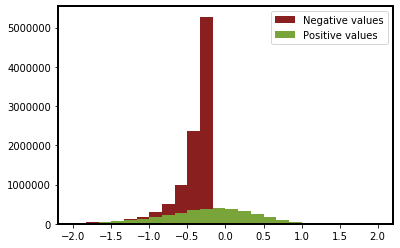

In [8]:
bins = np.linspace(-2, 2, 25)
plt.hist(np.log10(-mapvec[3].flatten()[mapvec[3].flatten() < 0]), bins=bins, label='Negative values')
plt.hist(np.log10(mapvec[3].flatten()[mapvec[3].flatten() > 0]), bins=bins, label='Positive values')
plt.legend()

Yes. 

# Difference maps of steps

Text(0.5, 1.0, 'Difference')

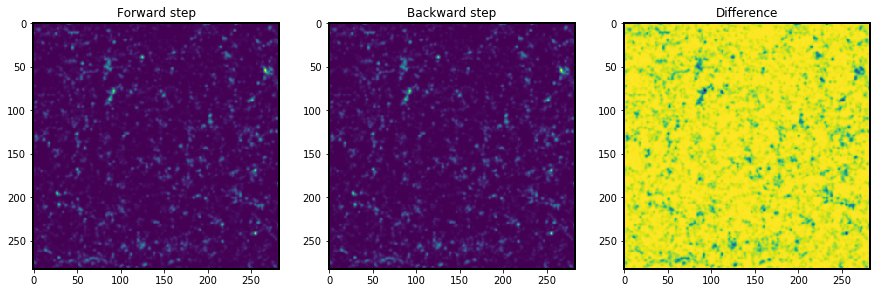

In [9]:
fig, ax = plt.subplots(nrows = 1, ncols=3, figsize=(15, 5))


ax[0].imshow(mapvec[2][23,:,:])
ax[0].set_title('Forward step')


ax[1].imshow(mapvec[3][23,:,:])
ax[1].set_title('Backward step')


ax[2].imshow((mapvec[2]-mapvec[3])[23,:,:])
ax[2].set_title('Difference')

Run these with and without changing T_sys to see the differences!